## To do:

1. Visualize the input data
2. Build a simple single layer network
3. Train it
3. Visualize the neuron activation patterns

## Input data

Input is provided via a CSV where each row describes a 28x28 grayscale image, each column lists pixels going from top-left, left-to-right. Training data has an additional label column prepended.

In [12]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
IMAGE_SIZE = 28
PIXEL_COUNT = IMAGE_SIZE ** 2

TRAIN_DATA_PATH = '../input/train.csv'
TEST_DATA_PATH = '../input/test.csv'
WEIGHTS_PATH = '../output/weights.h5'
PREDICTIONS_PATH = '../output/predictions.csv'

In [3]:
train_csv = pd.read_csv(TRAIN_DATA_PATH)
test_csv = pd.read_csv(TEST_DATA_PATH)

In [71]:
test_data = test_csv[:]
train_data = train_csv[:]
train_labels, train_data = train_data.iloc[:, :1], train_data.iloc[:, 1:]

In [72]:
def plot_images(images, labels, rows=3, cols=6):
    count = rows * cols
    images = images[:count]
    images = images.reshape(images.shape[0], IMAGE_SIZE, IMAGE_SIZE)
    
    for i in range(count):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap=plt.get_cmap('gray'))
        plt.title(labels[i])

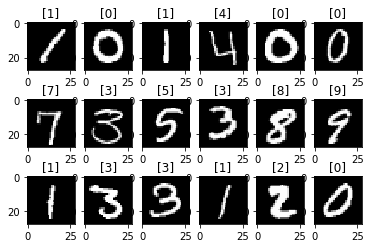

In [73]:
plot_images(train_data.as_matrix(), train_labels.as_matrix())

## Model

In [44]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()

# Input layer
model.add(Dense(32, input_shape=(PIXEL_COUNT,)))
model.add(Activation('relu'))

# Hidden layers
model.add(Dense(16, input_shape=(PIXEL_COUNT,)))
model.add(Activation('relu'))

# Output layer
model.add(Dense(10))
model.add(Activation('softmax'))

In [45]:
# Compile the model
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

## Training

In [ ]:
# Load weights
model.load_weights(WEIGHTS_PATH)

In [50]:
from keras import utils

# Convert labels to categorical one-hot encoding
train_labels_categorical = utils.to_categorical(train_labels, num_classes=10)

# Train the model, iterating on the data in batches of 32 samples
model.fit(
    train_data.as_matrix(), 
    train_labels_categorical, 
    epochs=10, 
    batch_size=32,
    validation_split=0.2,
)

Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 2s - loss: 0.8516 - acc: 0.8928 - val_loss: 0.9531 - val_acc: 0.9038
Epoch 2/10
33600/33600 [==============================] - 2s - loss: 0.8201 - acc: 0.8881 - val_loss: 0.8688 - val_acc: 0.8689
Epoch 3/10
33600/33600 [==============================] - 2s - loss: 0.8141 - acc: 0.8916 - val_loss: 0.9121 - val_acc: 0.8858
Epoch 4/10
33600/33600 [==============================] - 2s - loss: 0.8438 - acc: 0.8938 - val_loss: 0.8657 - val_acc: 0.9130
Epoch 5/10
33600/33600 [==============================] - 2s - loss: 0.8764 - acc: 0.9087 - val_loss: 0.8800 - val_acc: 0.8989
Epoch 6/10
33600/33600 [==============================] - 2s - loss: 0.8162 - acc: 0.9010 - val_loss: 0.8494 - val_acc: 0.9054
Epoch 7/10
33600/33600 [==============================] - 2s - loss: 0.8404 - acc: 0.9074 - val_loss: 0.8555 - val_acc: 0.9050
Epoch 8/10
33600/33600 [==============================] - 2s -

In [51]:
# Save weights
model.save_weights(WEIGHTS_PATH)

41664/42000 [============================>.] - ETA: 0s

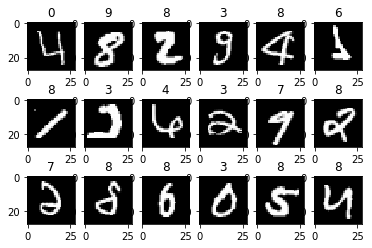

In [74]:
predicted_train_labels = model.predict_classes(
    train_data.as_matrix(),
    batch_size=32,
)
predicted_train_labels = pd.DataFrame({'predicted': predicted_train_labels})
comparison = pd.concat([train_labels, predicted_train_labels], axis=1)

fail_indices = comparison['label'] != comparison['predicted']
fail_labels = comparison[fail_indices]['predicted']
fail_data = train_data[fail_indices]

plot_images(fail_data.as_matrix(), fail_labels.as_matrix())

24992/28000 [=========================>....] - ETA: 0s

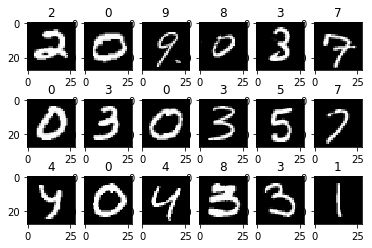

In [75]:
test_labels = model.predict_classes(
    test_data.as_matrix(),
    batch_size=32,
)

plot_images(test_data.as_matrix(), test_labels)

submission_data = pd.DataFrame({
    'ImageId': range(1, len(test_data) + 1),
    'Label': test_labels,
})
submission_data.to_csv(PREDICTIONS_PATH, index=False)